# Modeling
I also want to guess the valoration of a movie from the rest of information.

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('data\imdb_processed.csv')

### 1 - Selection
Some of the columns are not needed for modelling, but I need them for visualization.

In [3]:
non_model_info = data[['tconst', 'primaryTitle', 'startYear']]
non_model_info.head(1)

,tconst,primaryTitle,startYear
0,tt0023526,Stranger in Town,1932


In [4]:
data = data.drop(['tconst', 'primaryTitle', 'startYear'], axis=1)
data.head(1)

,isAdult,runtimeMinutes,rating,genres,mpaa,description,votes,year_process
0,0,65,6.1,['drama'],PG,"[""Ulysses Crickle owns a small town grocery st...",115.0,1932


I also want to keep the target separated:

In [5]:
target = data['rating']
data = data.drop('rating', axis=1)


In [13]:
data.head()

,isAdult,runtimeMinutes,genres,mpaa,description,votes,year_process
0,0,65,['drama'],PG,"[""Ulysses Crickle owns a small town grocery st...",115.0,1932
1,0,76,"['comedy', 'drama']",Not Rated,['_Strangers in Love_ (qv) is a 1932 American ...,144.0,1932
2,0,70,"['comedy', 'mystery']",Approved,['Bodies start mysteriously disappearing from ...,218.0,1932
3,0,59,"['drama', 'romance']",Approved,"[""A married architect, stuck in a loveless mar...",356.0,1932
4,0,99,['comedy'],Not Rated,['Whoever of a group of eager bicycle racers f...,14.0,1932


### 2 - Train/Test split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In order to improve accuracy in the models, I want to normalize the numerical data, and encode the categorical data.
Also, I have two columns that I want to treat differently.

In [16]:
# numerical = data.select_dtypes(np.number)
# text = data[['genres', 'description']]
# categorical = data['mpaa']

X_train_numerical = X_train.select_dtypes(np.number)
X_train_categorical = pd.DataFrame()
X_train_categorical['mpaa'] = X_train['mpaa'].copy()

X_test_numerical = X_test.select_dtypes(np.number)
X_test_categorical = pd.DataFrame()
X_test_categorical['mpaa'] = X_test['mpaa'].copy()

### 3 - Numerical Scaling
The numerical data has very different ranges, so I will scale them.

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
transformer = MinMaxScaler().fit(X_train_numerical)
X_train_num_tran = transformer.transform(X_train_numerical)

X_train_num_tran = pd.DataFrame(X_train_num_tran, columns=X_train_numerical.columns)
# X_train_num_tran.shape

X_test_num_tran = transformer.transform(X_test_numerical)

X_test_num_tran = pd.DataFrame(X_test_num_tran, columns=X_test_numerical.columns)


### 4 - Categorical Encoding
I need to transform the categories of the age ratings in the ``mpaa`` column to be numbers

In [19]:
X_test['mpaa'].value_counts()

Not Rated    4919
Approved     1932
R             393
PG            321
G             134
PG-13         134
NC-17         125
Name: mpaa, dtype: int64

In [20]:
dict = {'Not Rated': 0, 'Approved': 1, 'G': 2, 'PG': 3, 'PG-13': 4, 'R': 5, 'NC-17': 6}

X_train_cat_label = X_train_categorical.replace({"mpaa": dict}).reset_index(drop=True)

X_test_cat_label = X_test_categorical.replace({"mpaa": dict}).reset_index(drop=True)

### 5 - Putting everything back together

In [21]:
X_train_tran = pd.concat([X_train_num_tran, X_train_cat_label], axis=1)
# X_train_tran

In [22]:
X_test_tran = pd.concat([X_test_num_tran, X_test_cat_label], axis=1)
# X_test_tran

### 6 - Check correlations

In [23]:
import seaborn as sns

In [28]:
correlation = pd.concat([X_train_tran, y_train], axis=1)
correlation.shape

(38198, 6)

In [31]:
# corr = X_train_tran.corr()
corr = correlation.corr()

<AxesSubplot:>

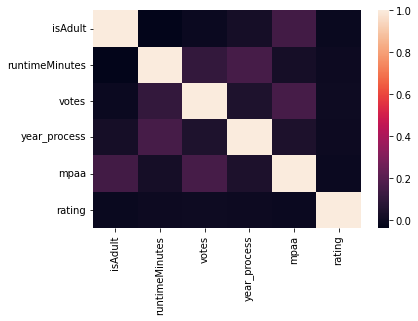

In [32]:
sns.heatmap(corr)

There are no correlations, but that might indicate that the data I have here is not related at all with the target.

### 7 - Models

In [33]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math

In [34]:
lm = linear_model.LinearRegression()
lm.fit(X_train_tran,y_train)

LinearRegression()

In [35]:
def metrics(X, y):
    #Finds and prints the metrics of the algorithm
    predictions = lm.predict(X)
    r2 = r2_score(y, predictions)
    print('R2:', r2)
    mse = np.sqrt(mean_squared_error(y,predictions))
    print('MSE:', mse)
    rmse = math.sqrt(mse)
    print('RMSE:', rmse)
    mae = mean_absolute_error(y, predictions)
    print('MAE:', mae)

In [36]:
metrics(X_test_tran,y_test)

R2: 0.04580805814119282
MSE: 1.083247390233663
RMSE: 1.0407917131845656
MAE: 0.823900065134208


This is a pretty bad R2 score...
That would make some sense, as the reception of the movie does not depend at all on the metrics I had access to. That is why even high budget movies can flop easily.

### 8 - Using the word matrix

In [126]:
data_tokenized = pd.read_csv('data\data_tokenized.csv')

In [127]:
target_token = data_tokenized['rating']
data_tokenized = data_tokenized.drop('rating', axis=1)
data_tokenized = data_tokenized.drop(['tconst', 'primaryTitle', 'startYear', 'description', 'tokens'], axis=1)


I also want to make a Bag of Genres, following the same process as with the words from the descriptions:

In [128]:
token_list = data_tokenized['genres'].tolist()
genre_list = []
regx  = '''[\[\]\"\']'''

import re

for token in token_list:
    token = re.sub(regx,'',token)
    list = token.split(', ')
    genre_list = genre_list + list

In [129]:
from nltk.probability import FreqDist

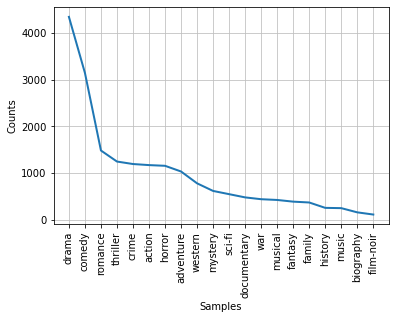

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [130]:
fd = FreqDist(genre_list)

fd.plot(20, cumulative=False)

In [131]:
fd.most_common(10)

[('drama', 4346),
 ('comedy', 3146),
 ('romance', 1486),
 ('thriller', 1250),
 ('crime', 1197),
 ('action', 1174),
 ('horror', 1159),
 ('adventure', 1037),
 ('western', 784),
 ('mystery', 621)]

In [132]:
def find_features_column(row):
    words = row['genres']
    features = {}
    for w in genre_list:
        features[w] = (w in words)

    return features

In [133]:
genre_dict = data_tokenized.apply(find_features_column, axis=1)

In [134]:
genre_df = pd.DataFrame(genre_dict.tolist())

In [135]:
data_tokenized = pd.concat([data_tokenized, genre_df], axis=1)

In [136]:
data_tokenized = data_tokenized.drop('genres', axis=1)

In [137]:
X_token_train, X_token_test, y_token_train, y_token_test = train_test_split(data_tokenized, target_token, test_size=0.2, random_state=42)

In [138]:
X_token_train_numerical = X_token_train.select_dtypes(np.number)
X_token_train_categorical = X_token_train.select_dtypes('object')
X_token_train_boolean = X_token_train.select_dtypes('bool')

X_token_test_numerical = X_token_test.select_dtypes(np.number)
X_token_test_categorical = X_token_test.select_dtypes('object')
X_token_test_boolean = X_token_test.select_dtypes('bool')

In [139]:
transformer_token = MinMaxScaler().fit(X_token_train_numerical)
X_token_train_num_tran = transformer_token.transform(X_token_train_numerical)

X_token_train_num_tran = pd.DataFrame(X_token_train_num_tran, columns=X_token_train_numerical.columns)

X_token_test_num_tran = transformer_token.transform(X_token_test_numerical)

X_token_test_num_tran = pd.DataFrame(X_token_test_num_tran, columns=X_token_test_numerical.columns)

In [140]:
dict = {'Not Rated': 0, 'Approved': 1, 'G': 2, 'PG': 3, 'PG-13': 4, 'R': 5, 'NC-17': 6}

X_token_train_cat_label = X_token_train_categorical.replace({"mpaa": dict}).reset_index(drop=True)

X_token_test_cat_label = X_token_test_categorical.replace({"mpaa": dict}).reset_index(drop=True)

In [141]:
X_token_test_categorical

,mpaa
5135,Not Rated
7921,Not Rated
1087,Not Rated
4826,Not Rated
10060,Approved
...,...
5769,Approved
8732,Approved
5566,Not Rated
8570,Not Rated


In [142]:
X_token_train_tran = pd.concat([X_token_train_num_tran.reset_index(drop=True), X_token_train_cat_label.reset_index(drop=True), X_token_train_boolean.reset_index(drop=True)], axis=1)
X_token_test_tran = pd.concat([X_token_test_num_tran.reset_index(drop=True), X_token_test_cat_label.reset_index(drop=True), X_token_test_boolean.reset_index(drop=True)], axis=1)


In [146]:
lm = linear_model.LinearRegression()
lm.fit(X_token_train_tran,y_token_train)

LinearRegression()

In [147]:
metrics(X_token_test_tran,y_token_test)

R2: -4.624512309594004e+18
MSE: 2969956588.061477
RMSE: 54497.308080872004
MAE: 92970164.65654074
